# 데이터 전처리

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Lion
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#패키지 import

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
#폰트 설치
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.0 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126441 files and direc

In [ ]:
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')

In [ ]:
df = df.set_index('관측일시')#인덱스로 설정

In [ ]:
#데이터 분리
target=['가뭄(MSWSI)','가뭄(SPI6)']
X=df.drop(target,axis=1)
y=df[target]


In [ ]:
# y[target] = y[target].replace({ 2: '극한습윤', 1.5: '심한습윤', 1: '보통습윤', 0.5: '약한습윤',0: '정상', -0.5: '약한가뭄', -1: '보통가뭄', -1.5: '심한가뭄', -2: '극한가뭄'})
# y[target] = y[target].astype('category')


In [ ]:
#train, test 데이터 나누기
test_size = 52#24년 데이터 개수
X_train, X_test = X[:-test_size], X[-test_size:]#독립변수 분할
y_train, y_test = y[:-test_size], y[-test_size:]#종속변수 분할

In [ ]:
from sklearn.preprocessing import RobustScaler
#스케일러 적용
scaler_robust = RobustScaler()
X_train_robust = scaler_robust.fit_transform(X_train)
X_test_robust = scaler_robust.transform(X_test)#test는 fit하지 않습니다(데이터누수 때문에)

#dataframe으로 변환
X_train_robust   = pd.DataFrame(X_train_robust, columns=X_train.columns, index=X_train.index)
X_test_robust    = pd.DataFrame(X_test_robust, columns=X_test.columns, index=X_test.index)

In [ ]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder(sparse_output=False)
# y_train_ohe  = ohe.fit_transform(y_train[['가뭄(MSWSI)', '가뭄(SPI6)']])
# y_test_ohe  = ohe.transform(y_test[['가뭄(MSWSI)', '가뭄(SPI6)']])#test는 fit하지 않습니다(데이터누수 때문에)
# encoded_y_train = pd.DataFrame(y_train_ohe, columns=ohe.get_feature_names_out(), index=y_train.index)
# encoded_y_test = pd.DataFrame(y_test_ohe, columns=ohe.get_feature_names_out(), index=y_test.index)


# 변수설명
X_train=독립변수 훈련데이터\
X_test=독립변수 테스트데이터\
y_test=종속변수 테스트데이터(원핫인코딩x)\
y_train=종속변수 훈련데이터(원핫인코딩x)\
encoded_y_trian=종속변수 테스트데이터(원핫인코딩o)\
encoded_y_test=종속변수 테스트데이터(원핫인코딩o)\
=================================================\
훈련데이터는 X_train_robust,encoded_y_trian 사용\
테스트 데이터는 X_test_robust,encoded_y_test 사용


# 일반 모델

lag feature 또는 모델의 파라미터를 바꿔가며 성능을 높여보려고함



In [ ]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# -------------------------------
# Lag feature 생성
# -------------------------------
# def create_lag_features(df, target_cols, lags=[1,2,3,7,14]):  # 장기 시점도 추가
#     df_lag = df.copy()
#     for col in target_cols:
#         for lag in lags:
#             df_lag[f'{col}_lag{lag}'] = df_lag[col].shift(lag)
#     return df_lag

def create_lag_features(df, target_cols, lags=[1,2,3,7,14,30]):  # 30일, 60일 추가
    df_lag = df.copy()
    for col in target_cols:
        for lag in lags:
            df_lag[f'{col}_lag{lag}'] = df_lag[col].shift(lag)
    return df_lag

lag_features = ['가뭄(MSWSI)', '가뭄(SPI6)']

# Train과 Test 합쳐서 Lag 생성
X_train_lag = create_lag_features(pd.concat([X_train_robust, y_train], axis=1), lag_features)
X_test_lag  = create_lag_features(pd.concat([X_test_robust, y_test], axis=1), lag_features)

# Lag로 인해 생긴 NaN 제거
X_train_lag = X_train_lag.dropna()
X_test_lag  = X_test_lag.dropna()

# 학습/테스트용 독립변수
feature_cols = X_train_lag.columns.difference(lag_features)
X_train_final = X_train_lag[feature_cols]
X_test_final  = X_test_lag[feature_cols]

# -------------------------------
# 종속변수 준비
# -------------------------------
encoded_y_train = pd.DataFrame(y_train_ohe, columns=ohe.get_feature_names_out(), index=y_train.index)
encoded_y_test  = pd.DataFrame(y_test_ohe, columns=ohe.get_feature_names_out(), index=y_test.index)

y_train_final = encoded_y_train.loc[X_train_final.index]
y_test_final  = encoded_y_test.loc[X_test_final.index]

# -------------------------------
# LightGBM 하이퍼파라미터 개선
# -------------------------------
# lgb_params = {
#     'objective': 'regression',
#     'learning_rate': 0.03,
#     'num_leaves': 50,
#     'max_depth': 7,
#     'n_estimators': 1000,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
#     'reg_alpha': 0.1,
#     'reg_lambda': 0.1,
#     'min_child_samples': 5,  # 분할 제한 완화
#     'verbose': -1,
#     'random_state': 42
# }

#2번째로 성능 좋음

# lgb_params = {
#     'objective': 'regression',
#     'learning_rate': 0.03,
#     'num_leaves': 90,          # 120 → 90 (복잡도 줄이기)
#     'max_depth': 7,
#     'n_estimators': 1200,      # 1000 → 1200 (조금 더 학습)
#     'subsample': 0.85,         # 0.8 → 0.85 (데이터 조금 더 사용)
#     'colsample_bytree': 0.9,   # 0.8 → 0.9 (특징 더 활용)
#     'reg_alpha': 0.2,          # 0.5 → 0.2 (L1 규제 완화)
#     'reg_lambda': 0.3,         # 0.5 → 0.3 (L2 규제 완화)
#     'min_child_samples': 10,   # 20 → 10 (작은 리프도 허용)
#     'verbose': -1,
#     'random_state': 42
# }

#제일 성능 좋았음

# lgb_params = {
#     'objective': 'regression',
#     'learning_rate': 0.025,
#     'num_leaves': 100,
#     'max_depth': 8,
#     'n_estimators': 1400,
#     'subsample': 0.85,
#     'colsample_bytree': 0.9,
#     'reg_alpha': 0.2,
#     'reg_lambda': 0.3,
#     'min_child_samples': 5,   # 10 → 5 (작은 리프 허용)
#     'verbose': -1,
#     'random_state': 42
# }

lgb_params = {
    'objective': 'regression',
    'learning_rate': 0.02,     # 조금 더 낮게 → 많은 feature에 대해 안정적 학습
    'num_leaves': 80,          # 중간 크기 (feature 많으니 31보다 크게)
    'max_depth': -1,           # 깊이 제한 해제 (num_leaves로 제어)
    'n_estimators': 1500,      # 충분히 학습
    'subsample': 0.8,          # row 샘플링
    'colsample_bytree': 0.7,   # feature 샘플링 조금 줄임 (과적합 방지)
    'reg_alpha': 0.2,          # L1 규제 ↑ (불필요한 변수 억제)
    'reg_lambda': 0.4,         # L2 규제 ↑ (가중치 안정화)
    'min_child_samples': 15,   # 너무 작은 leaf 방지 → 과적합 완화
    'verbose': -1,
    'random_state': 42
}

model = MultiOutputRegressor(LGBMRegressor(**lgb_params))

# -------------------------------
# K-Fold 교차검증으로 학습 안정화
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_folds = []

for train_idx, val_idx in kf.split(X_train_final):
    X_tr, X_val = X_train_final.iloc[train_idx], X_train_final.iloc[val_idx]
    y_tr, y_val = y_train_final.iloc[train_idx], y_train_final.iloc[val_idx]

    model.fit(X_tr, y_tr)
    y_val_pred = model.predict(X_val)

    fold_rmse = np.sqrt(np.mean((y_val.values - y_val_pred)**2))
    rmse_folds.append(fold_rmse)

print("교차검증 RMSE 평균:", np.mean(rmse_folds))

# -------------------------------
# 최종 학습 후 테스트
# -------------------------------
model.fit(X_train_final, y_train_final)
y_pred_ohe = model.predict(X_test_final)

rmse_list = []
for i in range(y_test_final.shape[1]):
    rmse = np.sqrt(mean_squared_error(y_test_final.iloc[:, i], y_pred_ohe[:, i]))
    rmse_list.append(rmse)

print("각 클래스별 RMSE:", rmse_list)
print("평균 RMSE:", np.mean(rmse_list))

# -------------------------------
# 예측값 레이블 변환
# -------------------------------
y_pred_labels = np.argmax(y_pred_ohe, axis=1)


교차검증 RMSE 평균: 0.26465764277685977
각 클래스별 RMSE: [np.float64(0.14987342147868138), np.float64(0.44375163537104145), np.float64(0.32122799391451745), np.float64(0.21323361042718472), np.float64(0.21396845631524922), np.float64(0.4842848080383207), np.float64(0.33784344483708056), np.float64(0.38621391649580716), np.float64(0.015304129389791742), np.float64(0.08777038549025022), np.float64(0.1238155505543872), np.float64(0.05576597168136683), np.float64(0.006094782276295531), np.float64(0.12260047321468055)]
평균 RMSE: 0.21155346996318963


제일 성능 좋은 모델로(아마 위의 코드가 맞음) 돌렸을 때 얼마나 잘 맞추는가를 보기 위한 코드

결과에 따르면 예측을 하나로만 함

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# -------------------------------
# 테스트셋 예측
# -------------------------------
y_pred_ohe = model.predict(X_test_final)

# -------------------------------
# 각 클래스별 RMSE 계산
# -------------------------------
rmse_list = []
for i, col in enumerate(y_test_final.columns):
    rmse = np.sqrt(mean_squared_error(y_test_final.iloc[:, i], y_pred_ohe[:, i]))
    rmse_list.append(rmse)
    print(f"{col} RMSE: {rmse:.4f}")

print("평균 RMSE:", np.mean(rmse_list))

# -------------------------------
# 예측값을 레이블로 변환
# -------------------------------
y_pred_labels = np.argmax(y_pred_ohe, axis=1)
y_test_labels = np.argmax(y_test_final.values, axis=1)

# -------------------------------
# 예측 vs 실제 비교 테이블 생성
# -------------------------------
comparison_df = pd.DataFrame({
    '실제': y_test_labels,
    '예측': y_pred_labels
}, index=X_test_final.index)

print("\n테스트셋 예측 비교:")
print(comparison_df.head(10))


가뭄(MSWSI)_극한습윤 RMSE: 0.1499
가뭄(MSWSI)_보통가뭄 RMSE: 0.4438
가뭄(MSWSI)_보통습윤 RMSE: 0.3212
가뭄(MSWSI)_심한가뭄 RMSE: 0.2132
가뭄(MSWSI)_심한습윤 RMSE: 0.2140
가뭄(MSWSI)_약한가뭄 RMSE: 0.4843
가뭄(MSWSI)_약한습윤 RMSE: 0.3378
가뭄(MSWSI)_정상 RMSE: 0.3862
가뭄(SPI6)_극한가뭄 RMSE: 0.0153
가뭄(SPI6)_보통가뭄 RMSE: 0.0878
가뭄(SPI6)_보통습윤 RMSE: 0.1238
가뭄(SPI6)_심한가뭄 RMSE: 0.0558
가뭄(SPI6)_심한습윤 RMSE: 0.0061
가뭄(SPI6)_정상 RMSE: 0.1226
평균 RMSE: 0.21155346996318963

테스트셋 예측 비교:
            실제  예측
관측일시              
2024-08-03   1  13
2024-08-10   1  13
2024-08-17   3  13
2024-08-24   1  13
2024-08-31   1  13
2024-09-07   1  13
2024-09-14   5  13
2024-09-21   6  13
2024-09-28   2  13
2024-10-05   5  13


위의 문제가 y의 원핫인코딩으로 인한 문제일 수 있다 생각하여 원래의 데이터를 사용하기로함

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# -------------------------------
# 1. Lag feature 생성
# -------------------------------
def create_lag_features(df, target_cols, lags=[1,2,3,7,14,30]):
    df_lag = df.copy()
    for col in target_cols:
        for lag in lags:
            df_lag[f'{col}_lag{lag}'] = df_lag[col].shift(lag)
    return df_lag

lag_features = ['가뭄(MSWSI)', '가뭄(SPI6)']

X_train_lag = create_lag_features(pd.concat([X_train_robust, y_train], axis=1), lag_features)
X_test_lag  = create_lag_features(pd.concat([X_test_robust, y_test], axis=1), lag_features)

X_train_lag = X_train_lag.dropna()
X_test_lag  = X_test_lag.dropna()

feature_cols = X_train_lag.columns.difference(lag_features)
X_train_final = X_train_lag[feature_cols]
X_test_final  = X_test_lag[feature_cols]

y_train_final = y_train.loc[X_train_final.index]
y_test_final  = y_test.loc[X_test_final.index]

# -------------------------------
# 각 타겟별 LightGBMClassifier 학습
# -------------------------------
models = {}
y_pred = pd.DataFrame(index=X_test_final.index)

for col in y_train_final.columns:
    clf = LGBMClassifier(
        objective='multiclass',
        num_class=y_train_final[col].nunique(),
        learning_rate=0.05,
        num_leaves=50,
        max_depth=7,
        n_estimators=1000,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_child_samples=5,
        class_weight='balanced',  # 소수 클래스 가중치
        verbose=-1,
        random_state=42
    )
    clf.fit(X_train_final, y_train_final[col])
    y_pred[col] = clf.predict(X_test_final)
    models[col] = clf



위의 결과에 대한 정확도를 그래프로 표현

MSWSI 전체 정확도: 0.2727
클래스별 정확도:
보통가뭄: 0.2000
심한가뭄: 0.0000
약한가뭄: 0.6250
약한습윤: 0.0000
보통습윤: 0.0000
극한습윤: 0.0000
심한습윤: 0.0000
정상: 0.0000


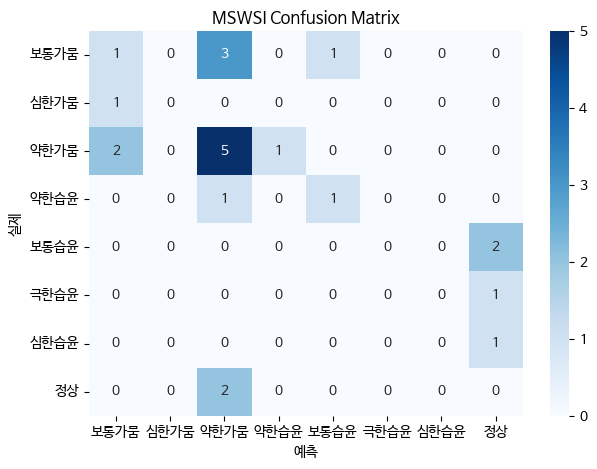

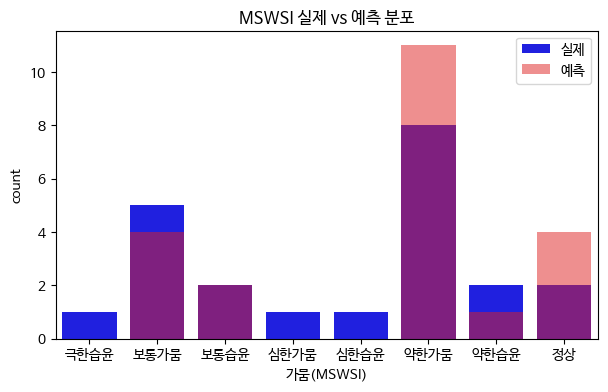

정확도 낮은 클래스: ['보통가뭄', '심한가뭄', '약한습윤', '보통습윤', '극한습윤', '심한습윤', '정상']


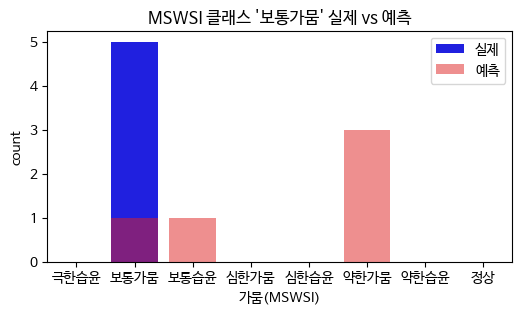

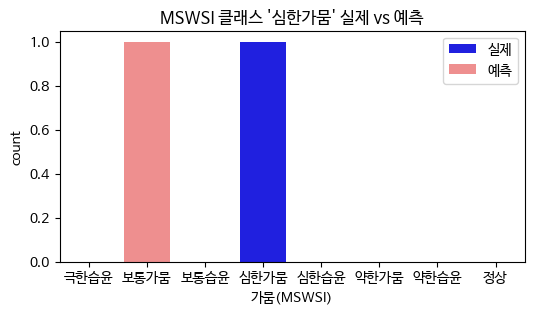

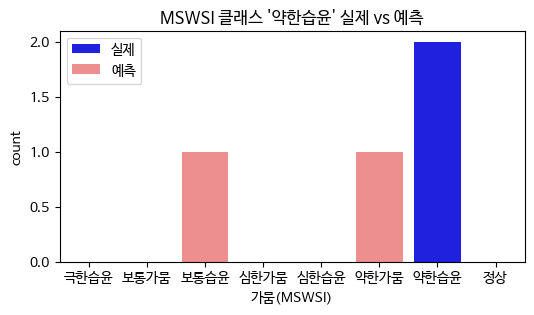

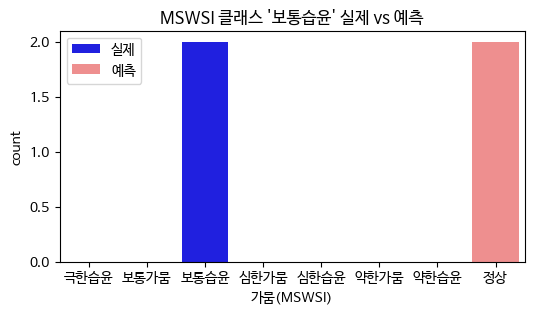

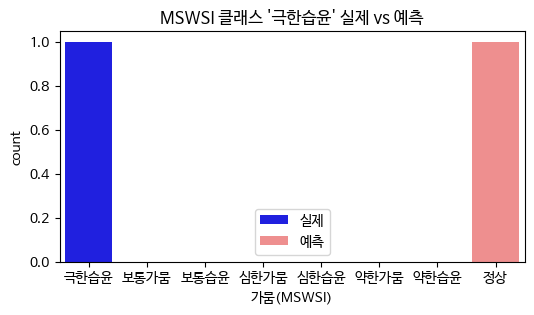

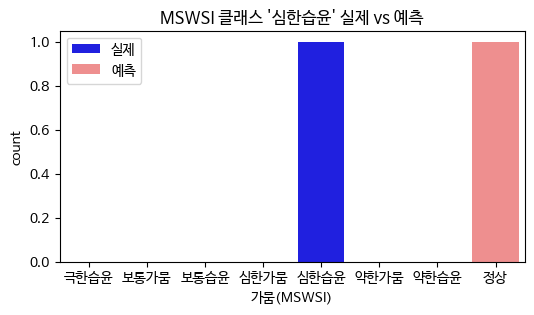

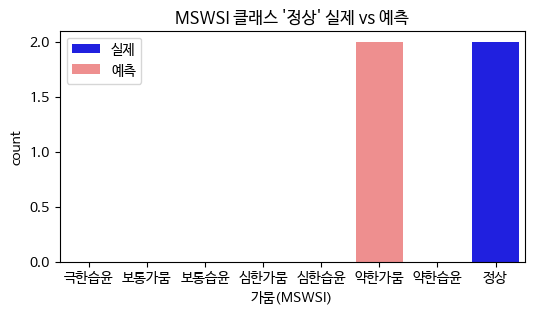

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# -------------------------------
# MSWSI 예측 결과 확인
# -------------------------------
mswsi_true = y_test_final['가뭄(MSWSI)']
mswsi_pred = y_pred['가뭄(MSWSI)']

# 전체 정확도
acc = accuracy_score(mswsi_true, mswsi_pred)
print(f"MSWSI 전체 정확도: {acc:.4f}")

# -------------------------------
# 클래스별 정확도 계산
# -------------------------------
classes = mswsi_true.unique()
class_acc = {}
for cls in classes:
    idx = mswsi_true == cls
    class_acc[cls] = accuracy_score(mswsi_true[idx], mswsi_pred[idx])

print("클래스별 정확도:")
for cls, a in class_acc.items():
    print(f"{cls}: {a:.4f}")

# -------------------------------
# Confusion Matrix 시각화
# -------------------------------
cm = confusion_matrix(mswsi_true, mswsi_pred, labels=classes)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("예측")
plt.ylabel("실제")
plt.title("MSWSI Confusion Matrix")
plt.show()

# -------------------------------
# 실제 vs 예측 분포 비교
# -------------------------------
plt.figure(figsize=(7,4))
sns.countplot(x=mswsi_true, color='blue', label='실제')
sns.countplot(x=mswsi_pred, color='red', alpha=0.5, label='예측')
plt.title("MSWSI 실제 vs 예측 분포")
plt.legend()
plt.show()

# -------------------------------
# 정확도 낮은 클래스 강조
# -------------------------------
low_acc_classes = [cls for cls, a in class_acc.items() if a < 0.5]
print("정확도 낮은 클래스:", low_acc_classes)

for cls in low_acc_classes:
    idx = mswsi_true == cls
    plt.figure(figsize=(6,3))
    sns.countplot(x=mswsi_true[idx], color='blue', label='실제')
    sns.countplot(x=mswsi_pred[idx], color='red', alpha=0.5, label='예측')
    plt.title(f"MSWSI 클래스 '{cls}' 실제 vs 예측")
    plt.legend()
    plt.show()


성능 높이는 작업

In [ ]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# -------------------------------
# RMSE 높은 클래스 리스트
# -------------------------------
high_rmse_cols = [
    y_train_final.columns[1],  # 0.373
    y_train_final.columns[5],  # 0.527
    y_train_final.columns[7],  # 0.449
    y_train_final.columns[10]  # 0.436
]

# -------------------------------
# 나머지 클래스: 기존 MultiOutputRegressor
# -------------------------------
other_cols = [c for c in y_train_final.columns if c not in high_rmse_cols]
model_multi = MultiOutputRegressor(LGBMRegressor(
    objective='regression',
    learning_rate=0.03,
    num_leaves=50,
    max_depth=7,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=5,
    verbose=-1,
    random_state=42
))
model_multi.fit(X_train_final, y_train_final[other_cols])

# -------------------------------
# RMSE 높은 클래스: 개별 모델로 튜닝
# -------------------------------
model_dict = {}
for col in high_rmse_cols:
    model_col = LGBMRegressor(
        objective='regression',
        learning_rate=0.02,   # 더 낮게 -> 안정화
        num_leaves=60,        # 더 큰 트리
        max_depth=8,
        n_estimators=1500,    # 더 많은 학습
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.2,
        reg_lambda=0.2,
        min_child_samples=3,
        verbose=-1,
        random_state=42
    )
    model_col.fit(X_train_final, y_train_final[col])
    model_dict[col] = model_col

# -------------------------------
# 예측 통합
# -------------------------------
y_pred_final = pd.DataFrame(index=X_test_final.index)

# 기존 모델 예측
y_pred_final[other_cols] = model_multi.predict(X_test_final)

# RMSE 높은 클래스 예측
for col in high_rmse_cols:
    y_pred_final[col] = model_dict[col].predict(X_test_final)

# -------------------------------
# 성능 평가
# -------------------------------
rmse_list = []
for col in y_test_final.columns:
    rmse = np.sqrt(mean_squared_error(y_test_final[col], y_pred_final[col]))
    rmse_list.append(rmse)

print("각 클래스별 RMSE:", rmse_list)
print("평균 RMSE:", np.mean(rmse_list))

# -------------------------------
# Optional: 레이블 변환
# -------------------------------
y_pred_labels = np.argmax(y_pred_final.values, axis=1)


각 클래스별 RMSE: [np.float64(0.14631505203505313), np.float64(0.35922229633611663), np.float64(0.25944263707515985), np.float64(0.1649065300934637), np.float64(0.14855030029439042), np.float64(0.5173899419152103), np.float64(0.29920351485939534), np.float64(0.42100069818766056), np.float64(0.009332503487787375), np.float64(0.09321899486351157), np.float64(0.4300991676381757), np.float64(0.05091519152458637), np.float64(0.003812292075677027), np.float64(0.264204195745772)]
평균 RMSE: 0.22625809400942568


성능 높이기 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# -------------------------------
# 기존 MultiOutput 모델 학습
# -------------------------------
base_model = MultiOutputRegressor(LGBMRegressor(
    objective='regression',
    learning_rate=0.03,
    num_leaves=50,
    max_depth=7,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=5,
    verbose=-1,
    random_state=42
))
base_model.fit(X_train_final, y_train_final)

# 초기 예측
y_pred_base = pd.DataFrame(base_model.predict(X_test_final), columns=y_test_final.columns, index=X_test_final.index)

# -------------------------------
# RMSE 계산 및 높은 RMSE 타겟 탐지
# -------------------------------
rmse_dict = {}
for col in y_test_final.columns:
    rmse_dict[col] = np.sqrt(mean_squared_error(y_test_final[col], y_pred_base[col]))

# RMSE 기준: 평균보다 크면 개선 필요
rmse_threshold = np.mean(list(rmse_dict.values()))
high_rmse_cols = [col for col, rmse in rmse_dict.items() if rmse > rmse_threshold]

print("RMSE 높은 타겟:", high_rmse_cols)

# -------------------------------
# 높은 RMSE 타겟 별도 모델 튜닝
# -------------------------------
high_model_dict = {}
for col in high_rmse_cols:
    model_col = LGBMRegressor(
        objective='regression',
        learning_rate=0.02,   # 안정화
        num_leaves=60,
        max_depth=8,
        n_estimators=1500,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_alpha=0.2,
        reg_lambda=0.2,
        min_child_samples=3,
        verbose=-1,
        random_state=42
    )
    model_col.fit(X_train_final, y_train_final[col])
    high_model_dict[col] = model_col

# -------------------------------
# 최종 예측 통합
# -------------------------------
y_pred_final = y_pred_base.copy()

for col in high_rmse_cols:
    y_pred_final[col] = high_model_dict[col].predict(X_test_final)

# -------------------------------
# 성능 평가
# -------------------------------
rmse_list = []
for col in y_test_final.columns:
    rmse = np.sqrt(mean_squared_error(y_test_final[col], y_pred_final[col]))
    rmse_list.append(rmse)

print("각 클래스별 RMSE:", rmse_list)
print("평균 RMSE:", np.mean(rmse_list))

# -------------------------------
# Optional: 레이블 변환
# -------------------------------
y_pred_labels = np.argmax(y_pred_final.values, axis=1)


RMSE 높은 타겟: ['가뭄(MSWSI)_보통가뭄', '가뭄(MSWSI)_보통습윤', '가뭄(MSWSI)_약한가뭄', '가뭄(MSWSI)_약한습윤', '가뭄(MSWSI)_정상', '가뭄(SPI6)_보통습윤', '가뭄(SPI6)_정상']
각 클래스별 RMSE: [np.float64(0.14631505203505313), np.float64(0.35922229633611663), np.float64(0.2817338637669516), np.float64(0.1649065300934637), np.float64(0.14855030029439042), np.float64(0.5173899419152103), np.float64(0.3037316307607819), np.float64(0.42100069818766056), np.float64(0.009332503487787375), np.float64(0.09321899486351157), np.float64(0.4300991676381757), np.float64(0.05091519152458637), np.float64(0.003812292075677027), np.float64(0.2649177455591619)]
평균 RMSE: 0.22822472918132344


성능 높이기 3

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 6.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# -------------------------------
# 기본 MultiOutput 모델 학습
# -------------------------------
base_model = MultiOutputRegressor(LGBMRegressor(
    objective='regression',
    learning_rate=0.03,
    num_leaves=50,
    max_depth=7,
    n_estimators=1000,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=0.1,
    min_child_samples=5,
    verbose=-1,
    random_state=42
))
base_model.fit(X_train_final, y_train_final)
y_pred_base = pd.DataFrame(base_model.predict(X_test_final),
                           columns=y_test_final.columns,
                           index=X_test_final.index)

# -------------------------------
# RMSE 계산 및 높은 RMSE 타겟 탐지
# -------------------------------
rmse_dict = {col: np.sqrt(mean_squared_error(y_test_final[col], y_pred_base[col]))
             for col in y_test_final.columns}
rmse_threshold = np.mean(list(rmse_dict.values()))
high_rmse_cols = [col for col, rmse in rmse_dict.items() if rmse > rmse_threshold]
print("RMSE 높은 타겟:", high_rmse_cols)

# -------------------------------
# Optuna를 이용한 하이퍼파라미터 최적화 함수
# -------------------------------
def objective(trial, X, y):
    param = {
        'objective': 'regression',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 3, 20),
        'verbose': -1,
        'random_state': 42
    }
    model = LGBMRegressor(**param)
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return rmse

# -------------------------------
# 높은 RMSE 타겟별 최적화 및 학습
# -------------------------------
optuna_models = {}
for col in high_rmse_cols:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X_train_final, y_train_final[col]), n_trials=30)
    best_params = study.best_params
    print(f"{col} 최적 하이퍼파라미터:", best_params)

    # 최적 하이퍼파라미터로 모델 학습
    best_model = LGBMRegressor(**best_params, verbose=-1, random_state=42)
    best_model.fit(X_train_final, y_train_final[col])
    optuna_models[col] = best_model

# -------------------------------
# 최종 예측 통합
# -------------------------------
y_pred_final = y_pred_base.copy()
for col in high_rmse_cols:
    y_pred_final[col] = optuna_models[col].predict(X_test_final)

# -------------------------------
# 성능 평가
# -------------------------------
rmse_list = [np.sqrt(mean_squared_error(y_test_final[col], y_pred_final[col]))
             for col in y_test_final.columns]
print("각 클래스별 RMSE:", rmse_list)
print("평균 RMSE:", np.mean(rmse_list))

# -------------------------------
# Optional: 레이블 변환
# -------------------------------
y_pred_labels = np.argmax(y_pred_final.values, axis=1)


[I 2025-09-25 05:06:22,430] A new study created in memory with name: no-name-600ed4d5-1783-4ee1-8921-9d8a6fb0937f


RMSE 높은 타겟: ['가뭄(MSWSI)_보통가뭄', '가뭄(MSWSI)_보통습윤', '가뭄(MSWSI)_약한가뭄', '가뭄(MSWSI)_약한습윤', '가뭄(MSWSI)_정상', '가뭄(SPI6)_보통습윤', '가뭄(SPI6)_정상']


/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
/tmp/ipython-input-367030540.py:52: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Thi

가뭄(MSWSI)_보통가뭄 최적 하이퍼파라미터: {'learning_rate': 0.0977189848924911, 'num_leaves': 49, 'max_depth': 10, 'n_estimators': 1835, 'subsample': 0.6643408765378362, 'colsample_bytree': 0.6455375732661608, 'reg_alpha': 0.0010060458285138327, 'reg_lambda': 0.01705082595559072, 'min_child_samples': 5}


[I 2025-09-25 05:06:48,112] A new study created in memory with name: no-name-9dab9b49-eebf-4523-a1c4-17035ab91575
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(MSWSI)_보통습윤 최적 하이퍼파라미터: {'learning_rate': 0.09748596261175765, 'num_leaves': 50, 'max_depth': 6, 'n_estimators': 1134, 'subsample': 0.7135332868059487, 'colsample_bytree': 0.9501425902565157, 'reg_alpha': 0.0010704585920426478, 'reg_lambda': 0.07058675748683955, 'min_child_samples': 9}


[I 2025-09-25 05:07:04,993] A new study created in memory with name: no-name-a346b505-b72d-4246-9665-43ab3da45465
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(MSWSI)_약한가뭄 최적 하이퍼파라미터: {'learning_rate': 0.09169199001196127, 'num_leaves': 33, 'max_depth': 10, 'n_estimators': 1927, 'subsample': 0.7376542343944875, 'colsample_bytree': 0.9999560456443968, 'reg_alpha': 0.0010273230611543773, 'reg_lambda': 0.0014725329003128903, 'min_child_samples': 15}


[I 2025-09-25 05:07:36,049] A new study created in memory with name: no-name-291c90a8-9348-44b0-a0c8-59af55a5008e
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(MSWSI)_약한습윤 최적 하이퍼파라미터: {'learning_rate': 0.025692192670111025, 'num_leaves': 100, 'max_depth': 6, 'n_estimators': 1863, 'subsample': 0.7279585098736816, 'colsample_bytree': 0.843088964385608, 'reg_alpha': 0.004669291409698411, 'reg_lambda': 0.43222628054730794, 'min_child_samples': 3}


[I 2025-09-25 05:07:59,673] A new study created in memory with name: no-name-a36d7968-89fd-41f9-b3b0-bc3ba7dd98b4
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(MSWSI)_정상 최적 하이퍼파라미터: {'learning_rate': 0.052690813435097336, 'num_leaves': 72, 'max_depth': 6, 'n_estimators': 1686, 'subsample': 0.8720873015700936, 'colsample_bytree': 0.9793049620318475, 'reg_alpha': 0.0016619089225480544, 'reg_lambda': 0.903180247087074, 'min_child_samples': 6}


[I 2025-09-25 05:08:34,770] A new study created in memory with name: no-name-f47cba59-e62c-4862-91ba-077eee852a4d
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(SPI6)_보통습윤 최적 하이퍼파라미터: {'learning_rate': 0.06159767107314748, 'num_leaves': 40, 'max_depth': 10, 'n_estimators': 1631, 'subsample': 0.6888951022072973, 'colsample_bytree': 0.7275282724560569, 'reg_alpha': 0.0011262083504481584, 'reg_lambda': 0.023454528495051957, 'min_child_samples': 5}


[I 2025-09-25 05:09:00,151] A new study created in memory with name: no-name-77fa3884-d3c5-4929-a7a7-1444d105b02f
/tmp/ipython-input-367030540.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
/tmp/ipython-input-367030540.py:50: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
/tmp/ipython-input-367030540.py:51: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0

가뭄(SPI6)_정상 최적 하이퍼파라미터: {'learning_rate': 0.05686366767872323, 'num_leaves': 63, 'max_depth': 9, 'n_estimators': 1153, 'subsample': 0.730801576236985, 'colsample_bytree': 0.9491064939963378, 'reg_alpha': 0.001957887298026779, 'reg_lambda': 0.6537036673501259, 'min_child_samples': 5}
각 클래스별 RMSE: [np.float64(0.14631505203505313), np.float64(0.3843579816678594), np.float64(0.25051511118645065), np.float64(0.1649065300934637), np.float64(0.14855030029439042), np.float64(0.5082694904678806), np.float64(0.30612871228591415), np.float64(0.4657002481682835), np.float64(0.009332503487787375), np.float64(0.09321899486351157), np.float64(0.43906323831040195), np.float64(0.05091519152458637), np.float64(0.003812292075677027), np.float64(0.2695665840248749)]
평균 RMSE: 0.2314751593204382


y의 -2부터 2까지의 데이터를 그대로 쓰기는 힘들어서 ordinal 변환을 함 (0부터 8까지)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


CV 평균 RMSE: 0.9484, 정확도: 0.5107, F1: 0.2941
테스트 RMSE: 1.3669, 정확도: 0.3684, F1: 0.1563


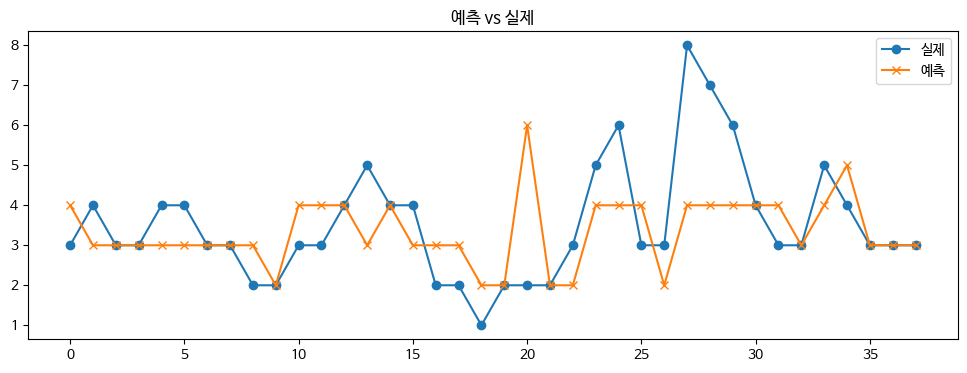

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CV 평균 RMSE: 0.6107, 정확도: 0.8732, F1: 0.4909
테스트 RMSE: 0.8584, 정확도: 0.8158, F1: 0.4493


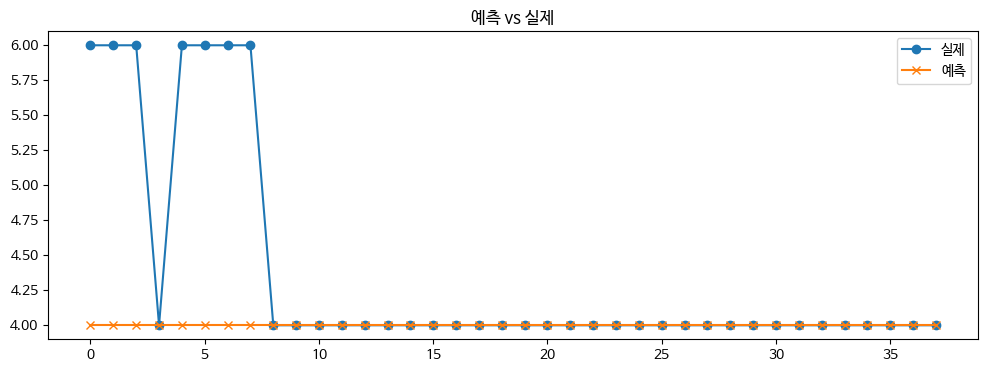

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt

# -------------------------------
# Lag feature 생성 함수
# -------------------------------
def create_lag_features(df, target_cols, lags=[1,2,3,7,14]):
    df_lag = df.copy()
    for col in target_cols:
        for lag in lags:
            df_lag[f'{col}_lag{lag}'] = df_lag[col].shift(lag)
    return df_lag

# -------------------------------
# 데이터 준비
# -------------------------------
target = ['가뭄(MSWSI)', '가뭄(SPI6)']
X = df.drop(target, axis=1)
y = df[target]

test_size = 52
X_train, X_test = X[:-test_size], X[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]

# -------------------------------
# Lag feature 추가
# -------------------------------
lag_cols = ['가뭄(MSWSI)', '가뭄(SPI6)']
X_train_lag = create_lag_features(pd.concat([X_train, y_train], axis=1), lag_cols)
X_test_lag  = create_lag_features(pd.concat([X_test, y_test], axis=1), lag_cols)

# NaN 제거
X_train_lag = X_train_lag.dropna()
X_test_lag  = X_test_lag.dropna()

# 독립변수 / 종속변수
feature_cols = X_train_lag.columns.difference(lag_cols)
X_train_final = X_train_lag[feature_cols]
X_test_final  = X_test_lag[feature_cols]

# Ordinal 변환
def ordinal_bin(y):
    return ((y + 2) * 2).astype(int)

y_train_mswsi = ordinal_bin(y_train.loc[X_train_final.index, '가뭄(MSWSI)'])
y_test_mswsi  = ordinal_bin(y_test.loc[X_test_final.index, '가뭄(MSWSI)'])
y_train_spi6  = ordinal_bin(y_train.loc[X_train_final.index, '가뭄(SPI6)'])
y_test_spi6   = ordinal_bin(y_test.loc[X_test_final.index, '가뭄(SPI6)'])

# -------------------------------
# 스케일링
# -------------------------------
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_final), columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_final), columns=X_test_final.columns, index=X_test_final.index)

# -------------------------------
# LightGBM 학습/평가 함수
# -------------------------------
def train_evaluate_lgb(X_train, y_train, X_test, y_test, params=None, n_splits=5):
    if params is None:
        params = {
            'objective': 'multiclass',
            'num_class': len(np.unique(y_train)),
            'learning_rate': 0.07,
            'num_leaves': 63,
            'max_depth': 10,
            'n_estimators': 1200,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'reg_alpha': 0.01,
            'reg_lambda': 0.5,
            'min_child_samples': 5,
            'random_state': 42
        }

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_list, acc_list, f1_list = [], [], []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)

        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        acc_list.append(accuracy_score(y_val, y_val_pred))
        f1_list.append(f1_score(y_val, y_val_pred, average='macro'))

    model_final = LGBMClassifier(**params)
    model_final.fit(X_train, y_train)
    y_pred = model_final.predict(X_test)

    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    acc_test  = accuracy_score(y_test, y_pred)
    f1_test   = f1_score(y_test, y_pred, average='macro')

    print(f"CV 평균 RMSE: {np.mean(rmse_list):.4f}, 정확도: {np.mean(acc_list):.4f}, F1: {np.mean(f1_list):.4f}")
    print(f"테스트 RMSE: {rmse_test:.4f}, 정확도: {acc_test:.4f}, F1: {f1_test:.4f}")

    # 예측 그래프
    plt.figure(figsize=(12,4))
    plt.plot(y_test.values, marker='o', label='실제')
    plt.plot(y_pred, marker='x', label='예측')
    plt.title('예측 vs 실제')
    plt.legend()
    plt.show()

    return model_final, y_pred

# -------------------------------
# MSWSI 모델
# -------------------------------
mswsi_model, y_pred_mswsi = train_evaluate_lgb(X_train_scaled, y_train_mswsi, X_test_scaled, y_test_mswsi)

# -------------------------------
# SPI6 모델
# -------------------------------
spi6_model, y_pred_spi6 = train_evaluate_lgb(X_train_scaled, y_train_spi6, X_test_scaled, y_test_spi6)




최적의 파라미터 찾는 작업도 동시에 진행






[I 2025-09-25 06:24:26,953] A new study created in memory with name: no-name-d3cee5c0-182d-4f06-9765-9bc061a49f89



### 가뭄(MSWSI) - Optuna 튜닝 중 ###


[I 2025-09-25 06:24:28,830] Trial 0 finished with value: 1.1206237507888426 and parameters: {'learning_rate': 0.11304644480308104, 'num_leaves': 100, 'max_depth': 10, 'n_estimators': 335, 'subsample': 0.9398709818520177, 'colsample_bytree': 0.7570790366058838, 'reg_alpha': 0.6168863462147415, 'reg_lambda': 0.9439476159648034, 'min_child_samples': 9}. Best is trial 0 with value: 1.1206237507888426.
[I 2025-09-25 06:24:30,112] Trial 1 finished with value: 1.1717725141749737 and parameters: {'learning_rate': 0.17447498089679558, 'num_leaves': 98, 'max_depth': 10, 'n_estimators': 1427, 'subsample': 0.926747368606343, 'colsample_bytree': 0.5352836894849953, 'reg_alpha': 0.5992141568088933, 'reg_lambda': 0.3120592921668224, 'min_child_samples': 9}. Best is trial 0 with value: 1.1206237507888426.
[I 2025-09-25 06:24:31,146] Trial 2 finished with value: 1.1331029572150966 and parameters: {'learning_rate': 0.1965342288380946, 'num_leaves': 31, 'max_depth': 15, 'n_estimators': 1074, 'subsample':

Best params: {'learning_rate': 0.1439452452486548, 'num_leaves': 64, 'max_depth': 7, 'n_estimators': 889, 'subsample': 0.6669001663694326, 'colsample_bytree': 0.7686635310446456, 'reg_alpha': 0.9623691362435187, 'reg_lambda': 0.22374867030895307, 'min_child_samples': 16}


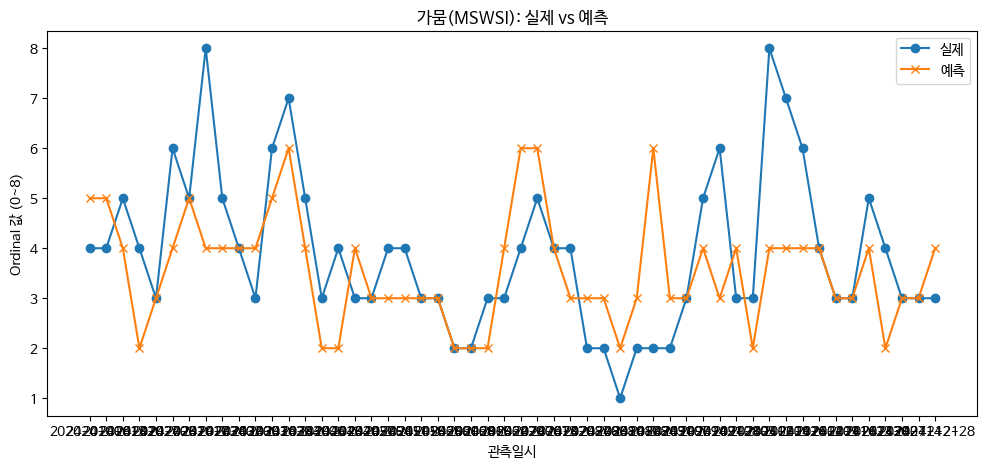

[I 2025-09-25 06:25:18,505] A new study created in memory with name: no-name-1f2b5f31-0071-44f9-a780-1cc2bcac6799



### 가뭄(SPI6) - Optuna 튜닝 중 ###


[I 2025-09-25 06:25:19,289] Trial 0 finished with value: 1.0990153338672208 and parameters: {'learning_rate': 0.18155789348079127, 'num_leaves': 97, 'max_depth': 6, 'n_estimators': 1199, 'subsample': 0.9365136690960492, 'colsample_bytree': 0.5526772833229752, 'reg_alpha': 0.18839514039703198, 'reg_lambda': 0.2678777041389584, 'min_child_samples': 3}. Best is trial 0 with value: 1.0990153338672208.
[I 2025-09-25 06:25:20,607] Trial 1 finished with value: 1.0952664094623272 and parameters: {'learning_rate': 0.0935332743632631, 'num_leaves': 76, 'max_depth': 6, 'n_estimators': 749, 'subsample': 0.807252793963227, 'colsample_bytree': 0.9491798628211225, 'reg_alpha': 0.07041519254521178, 'reg_lambda': 0.28715243591758643, 'min_child_samples': 3}. Best is trial 1 with value: 1.0952664094623272.
[I 2025-09-25 06:25:21,421] Trial 2 finished with value: 1.1164376228519044 and parameters: {'learning_rate': 0.10581154059935993, 'num_leaves': 72, 'max_depth': 13, 'n_estimators': 974, 'subsample': 

Best params: {'learning_rate': 0.0859915774504371, 'num_leaves': 61, 'max_depth': 7, 'n_estimators': 1176, 'subsample': 0.54924894581628, 'colsample_bytree': 0.5504304621199336, 'reg_alpha': 0.09484146452613569, 'reg_lambda': 0.8293511321700023, 'min_child_samples': 4}


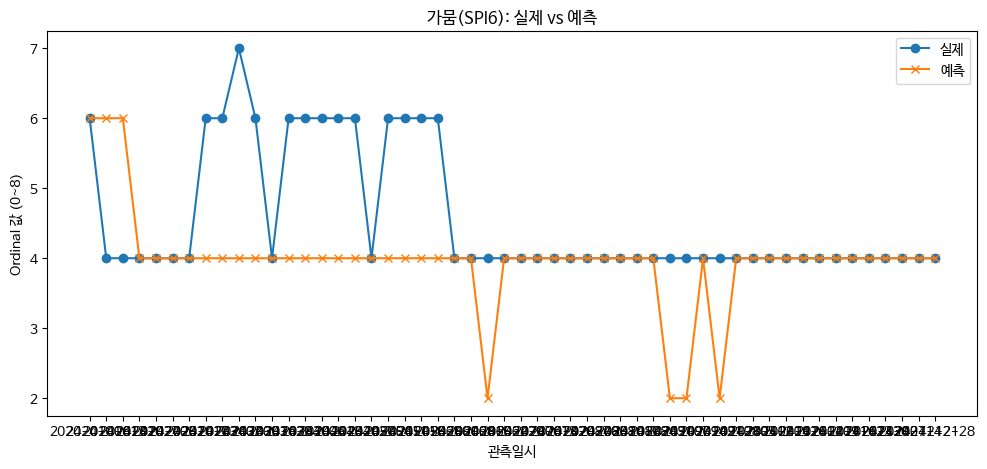

=== 가뭄(MSWSI) ===
CV 평균 RMSE: 1.0804, Accuracy: 0.4129, F1: 0.2634, Precision: 0.2706, Recall: 0.2681
테스트 RMSE: 1.4936, Accuracy: 0.2885, F1: 0.1452, Precision: 0.1460, Recall: 0.1510

=== 가뭄(SPI6) ===
CV 평균 RMSE: 1.0816, Accuracy: 0.7788, F1: 0.3166, Precision: 0.4239, Recall: 0.3055
테스트 RMSE: 1.2481, Accuracy: 0.6346, F1: 0.2240, Precision: 0.2611, Recall: 0.2298



In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import optuna

# -------------------------------
# Ordinal 변환 (0~8)
# -------------------------------
def ordinal_bin(y):
    return ((y + 2) * 2).astype(int)

# -------------------------------
# LightGBM 학습/평가 함수
# -------------------------------
def train_evaluate_lgb(X_train, y_train, X_test, y_test, params=None):
    model = LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        random_state=42,
        **params
    )

    # K-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_rmse, cv_acc, cv_f1, cv_prec, cv_rec = [], [], [], [], []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        model.fit(X_tr, y_tr)
        y_val_pred = model.predict(X_val)
        cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        cv_acc.append(accuracy_score(y_val, y_val_pred))
        cv_f1.append(f1_score(y_val, y_val_pred, average='macro'))
        cv_prec.append(precision_score(y_val, y_val_pred, average='macro', zero_division=0))
        cv_rec.append(recall_score(y_val, y_val_pred, average='macro', zero_division=0))

    # 전체 학습 후 테스트 평가
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_acc  = accuracy_score(y_test, y_pred)
    test_f1   = f1_score(y_test, y_pred, average='macro')
    test_prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    test_rec  = recall_score(y_test, y_pred, average='macro', zero_division=0)

    return model, y_pred, np.mean(cv_rmse), np.mean(cv_acc), np.mean(cv_f1), np.mean(cv_prec), np.mean(cv_rec), test_rmse, test_acc, test_f1, test_prec, test_rec

# -------------------------------
# Optuna 하이퍼파라미터 튜닝
# -------------------------------
def optuna_lgb(X_train, y_train, n_trials=30):
    def objective(trial):
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1500),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
            'min_child_samples': trial.suggest_int('min_child_samples', 3, 20),
        }
        model = LGBMClassifier(objective='multiclass', num_class=len(np.unique(y_train)), random_state=42, **params)
        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []
        for train_idx, val_idx in kf.split(X_train):
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            model.fit(X_tr, y_tr)
            y_val_pred = model.predict(X_val)
            rmses.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        return np.mean(rmses)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

# -------------------------------
# 대상 컬럼
# -------------------------------
targets = ['가뭄(MSWSI)', '가뭄(SPI6)']

# -------------------------------
# 결과 저장용
# -------------------------------
results = {}

for target_col in targets:
    # Ordinal 변환
    y = ordinal_bin(df[target_col])

    # 독립 변수
    X = df.drop(['가뭄(MSWSI)', '가뭄(SPI6)'], axis=1)

    # 스케일링
    scaler = RobustScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # 테스트셋 분할
    test_size = 52
    X_train, X_test = X_scaled[:-test_size], X_scaled[-test_size:]
    y_train, y_test = y[:-test_size], y[-test_size:]

    # -------------------------------
    # Optuna 튜닝
    # -------------------------------
    print(f"\n### {target_col} - Optuna 튜닝 중 ###")
    best_params = optuna_lgb(X_train, y_train, n_trials=30)
    print("Best params:", best_params)

    # -------------------------------
    # 학습/평가
    # -------------------------------
    model, y_pred, cv_rmse, cv_acc, cv_f1, cv_prec, cv_rec, test_rmse, test_acc, test_f1, test_prec, test_rec = train_evaluate_lgb(
        X_train, y_train, X_test, y_test, params=best_params
    )

    # 결과 저장
    results[target_col] = {
        'model': model,
        'y_test': y_test,
        'y_pred': y_pred,
        'cv_rmse': cv_rmse,
        'cv_acc': cv_acc,
        'cv_f1': cv_f1,
        'cv_prec': cv_prec,
        'cv_rec': cv_rec,
        'test_rmse': test_rmse,
        'test_acc': test_acc,
        'test_f1': test_f1,
        'test_prec': test_prec,
        'test_rec': test_rec
    }

    # -------------------------------
    # 테스트셋 그래프
    # -------------------------------
    plt.figure(figsize=(12,5))
    plt.plot(y_test.index, y_test.values, label='실제', marker='o')
    plt.plot(y_test.index, y_pred, label='예측', marker='x')
    plt.title(f'{target_col}: 실제 vs 예측')
    plt.xlabel('관측일시')
    plt.ylabel('Ordinal 값 (0~8)')
    plt.legend()
    plt.show()

# -------------------------------
# 최종 결과 출력
# -------------------------------
for target_col in targets:
    r = results[target_col]
    print(f"=== {target_col} ===")
    print(f"CV 평균 RMSE: {r['cv_rmse']:.4f}, Accuracy: {r['cv_acc']:.4f}, F1: {r['cv_f1']:.4f}, Precision: {r['cv_prec']:.4f}, Recall: {r['cv_rec']:.4f}")
    print(f"테스트 RMSE: {r['test_rmse']:.4f}, Accuracy: {r['test_acc']:.4f}, F1: {r['test_f1']:.4f}, Precision: {r['test_prec']:.4f}, Recall: {r['test_rec']:.4f}")
    print()


feauter 중요도, shap 의 결과치 (최적의 파라미터로)

=== MSWSI ===
RMSE: 1.4871, 정확도: 0.2500, F1: 0.1332


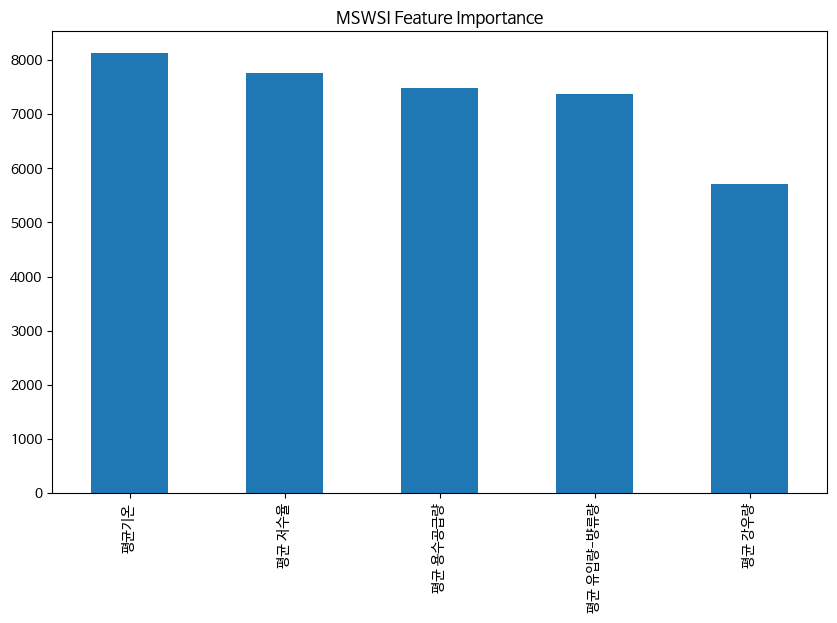

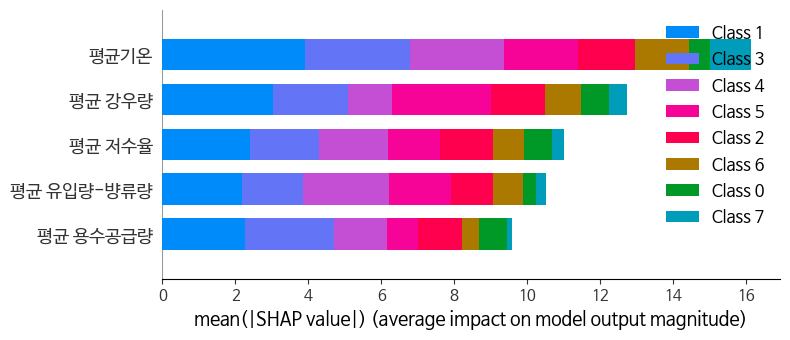

=== SPI6 ===
RMSE: 1.4005, 정확도: 0.6346, F1: 0.1796


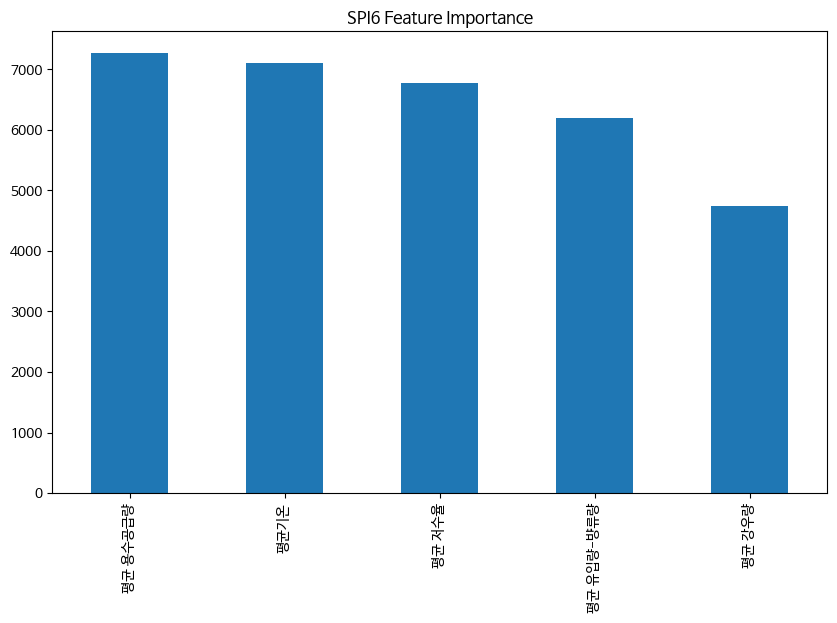

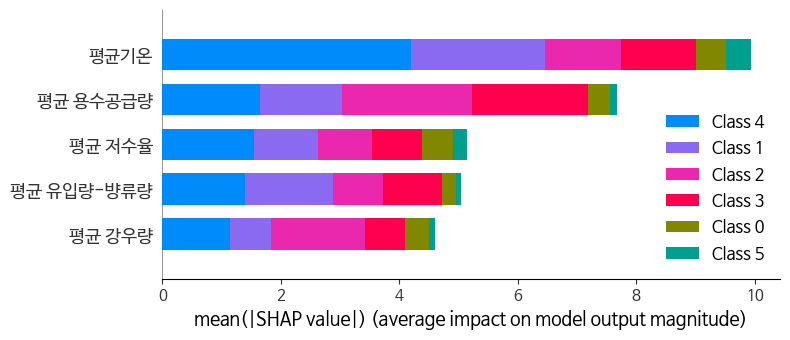

In [ ]:
# -------------------------------
# 파라미터 설정
# -------------------------------
mswsi_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_mswsi)),
    'learning_rate': 0.143945245248654,
    'num_leaves': 64,
    'n_estimators': 889,
    'max_depth': 7,
    'random_state': 42
}

spi6_params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_spi6)),
    'learning_rate': 0.08599157745,
    'num_leaves': 61,
    'n_estimators': 1176,
    'max_depth': 7,
    'random_state': 42
}

# -------------------------------
# 학습 + 평가 함수 (파라미터 입력 가능)
# -------------------------------
def train_evaluate_shap_params(X_tr, y_tr, X_te, y_te, name, lgb_params):
    model = LGBMClassifier(**lgb_params)
    model.fit(X_tr, y_tr)

    # 예측
    y_pred = model.predict(X_te)

    # 성능
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    acc  = accuracy_score(y_te, y_pred)
    f1   = f1_score(y_te, y_pred, average='macro')

    print(f"=== {name} ===")
    print(f"RMSE: {rmse:.4f}, 정확도: {acc:.4f}, F1: {f1:.4f}")

    # Feature Importance
    plt.figure(figsize=(10,6))
    lgb_importance = pd.Series(model.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
    lgb_importance.plot(kind='bar')
    plt.title(f'{name} Feature Importance')
    plt.show()

    # SHAP
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_te)
    shap.summary_plot(shap_values, X_te, plot_type="bar", show=True)

    return model, y_pred, rmse, acc, f1

# -------------------------------
# MSWSI 학습
# -------------------------------
mswsi_model, y_pred_mswsi, mswsi_rmse, mswsi_acc, mswsi_f1 = train_evaluate_shap_params(
    X_train_scaled, y_train_mswsi, X_test_scaled, y_test_mswsi, "MSWSI", mswsi_params
)

# -------------------------------
# SPI6 학습
# -------------------------------
spi6_model, y_pred_spi6, spi6_rmse, spi6_acc, spi6_f1 = train_evaluate_shap_params(
    X_train_scaled, y_train_spi6, X_test_scaled, y_test_spi6, "SPI6", spi6_params
)


# 3개 범주로 축소


===== 가뭄(MSWSI) 모델 학습 =====
Accuracy : 0.5873
Precision: 0.5636
Recall   : 0.5873
F1-score : 0.5459


<Figure size 1000x600 with 0 Axes>

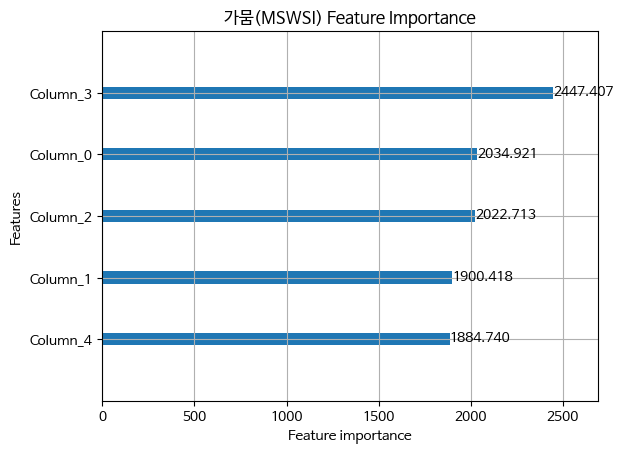

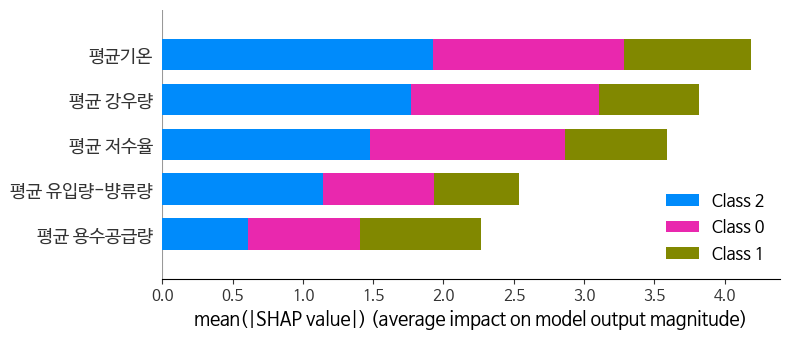

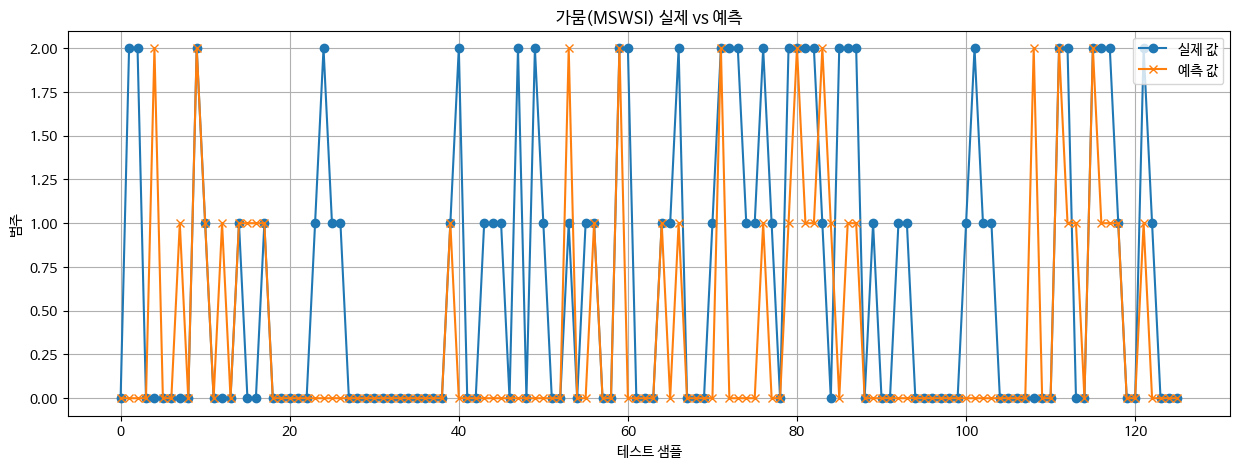


===== 가뭄(SPI6) 모델 학습 =====
Accuracy : 0.6984
Precision: 0.7386
Recall   : 0.6984
F1-score : 0.7142


<Figure size 1000x600 with 0 Axes>

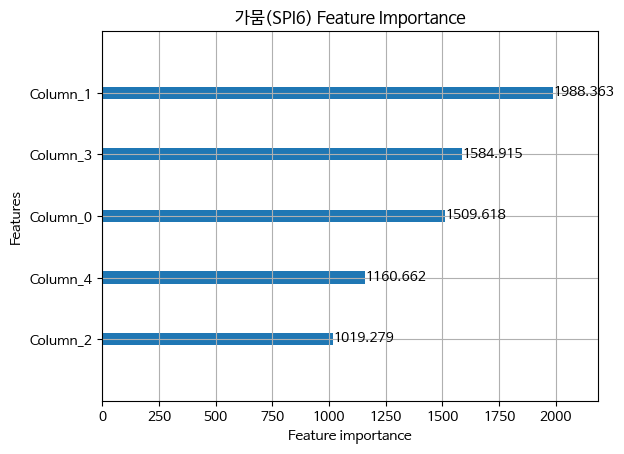

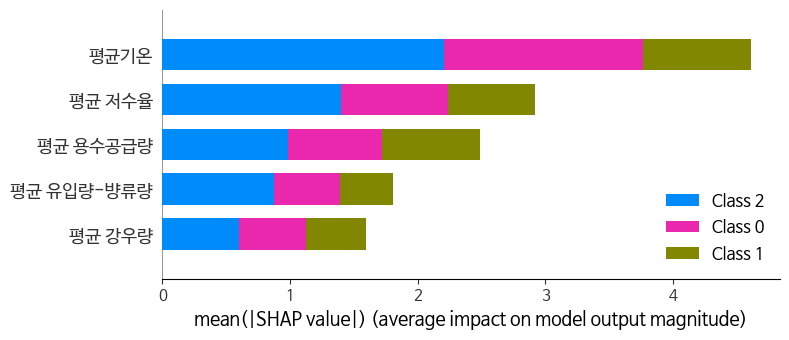

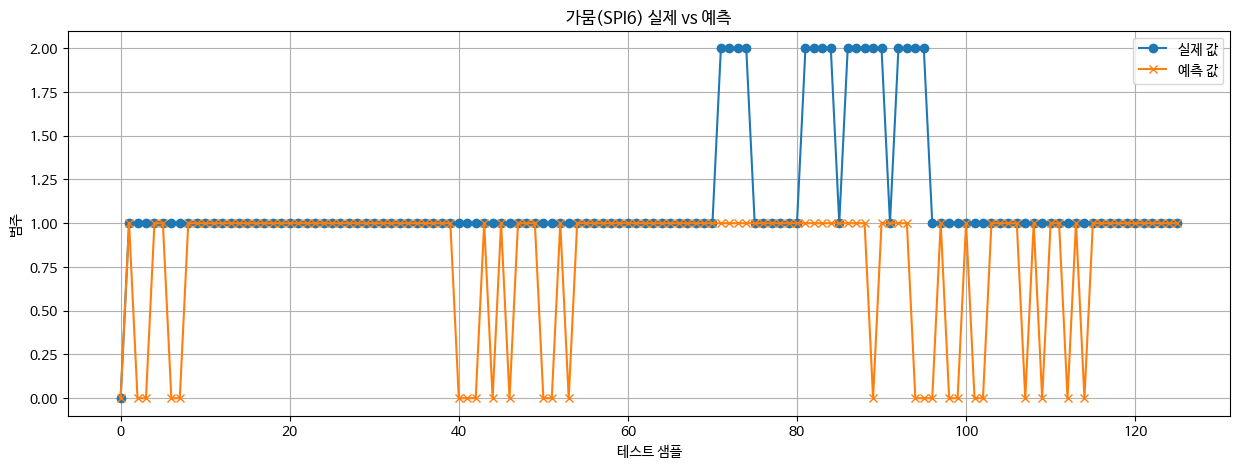

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 데이터 준비
# -----------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
X = df.drop(['관측일시', '가뭄(MSWSI)', '가뭄(SPI6)'], axis=1)
targets = ['가뭄(MSWSI)', '가뭄(SPI6)']

# -----------------------------
# y 3개 범주로 변환 함수
# -----------------------------
def categorize_y_3class(y):
    y_cat = []
    for val in y:
        if val < 0:
            y_cat.append(0)   # 음수
        elif val == 0:
            y_cat.append(1)   # 0
        else:
            y_cat.append(2)   # 양수
    return np.array(y_cat)

# -----------------------------
# 스케일링
# -----------------------------
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------
# LightGBM 공통 파라미터
# -----------------------------
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# -----------------------------
# 각 타겟별 학습
# -----------------------------
results = {}
for target in targets:
    print(f"\n===== {target} 모델 학습 =====")

    y = categorize_y_3class(df[target])

    # train/test 분할 (80:20, shuffle=False)
    split_idx = int(len(X_scaled)*0.8)
    X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval  = lgb.Dataset(X_test, label=y_test, reference=lgb_train)

    # 학습
    model = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,
    valid_sets=[lgb_train, lgb_eval]  # 평가용
)

    # 예측
    y_pred_prob = model.predict(X_test)
    y_pred_class = np.argmax(y_pred_prob, axis=1)

    # 평가
    acc  = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred_class, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_pred_class, average='weighted', zero_division=0)

    results[target] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_class
    }

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # -----------------------------
    # Feature Importance
    plt.figure(figsize=(10,6))
    lgb.plot_importance(model, max_num_features=15, importance_type='gain')
    plt.title(f'{target} Feature Importance')
    plt.show()

    # -----------------------------
    # SHAP 값 계산 및 시각화
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)

    # -----------------------------
    # 실제 vs 예측 그래프
    plt.figure(figsize=(15,5))
    plt.plot(y_test, label='실제 값', marker='o')
    plt.plot(y_pred_class, label='예측 값', marker='x')
    plt.title(f'{target} 실제 vs 예측')
    plt.xlabel('테스트 샘플')
    plt.ylabel('범주')
    plt.legend()
    plt.grid(True)
    plt.show()



===== 가뭄(MSWSI) 모델 학습 =====
Accuracy : 0.5952
Precision: 0.5794
Recall   : 0.5952
F1-score : 0.5506


<Figure size 1000x600 with 0 Axes>

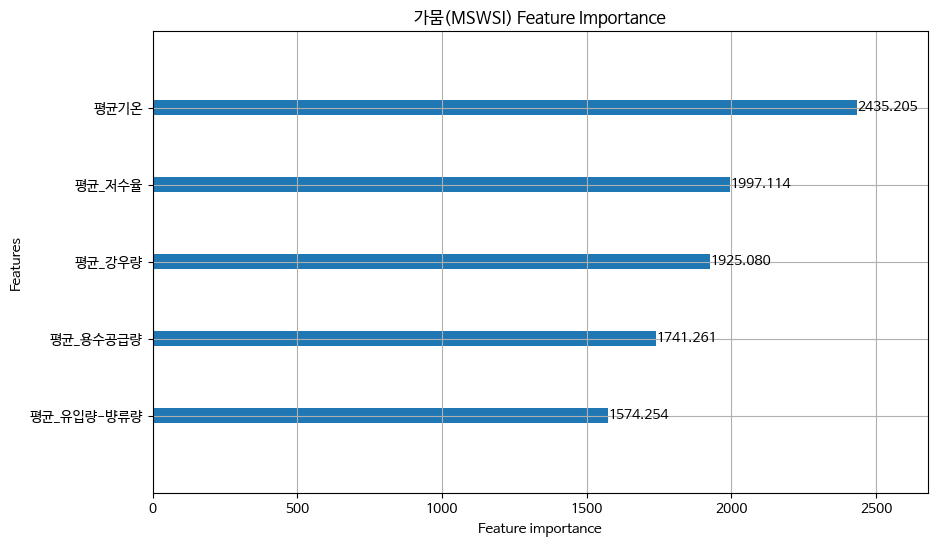

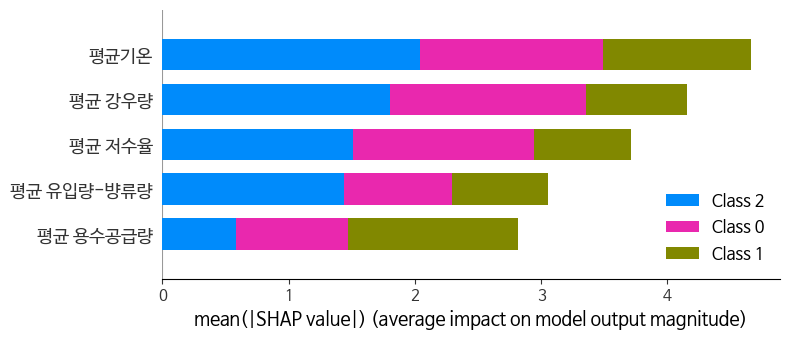

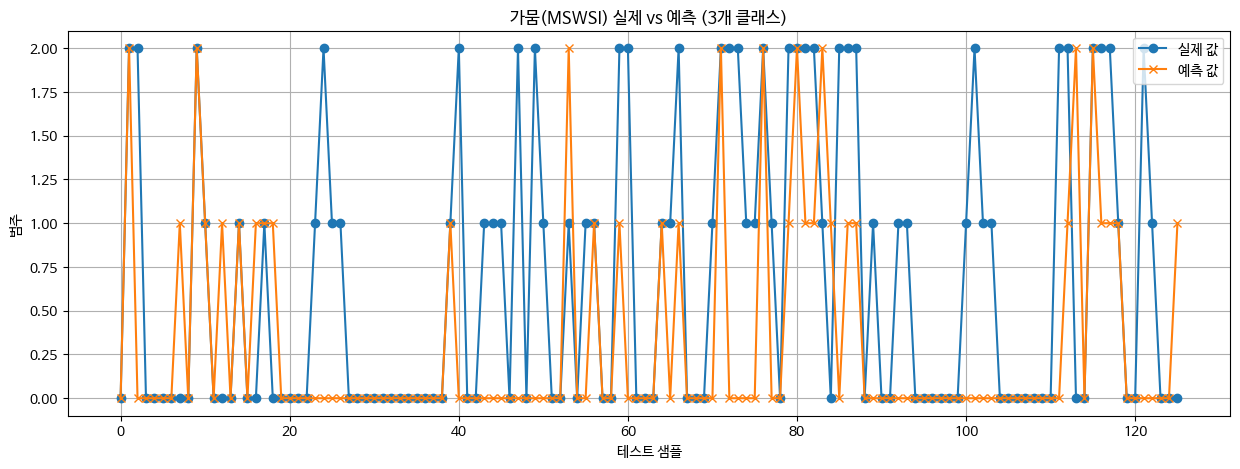


===== 가뭄(SPI6) 모델 학습 =====
Accuracy : 0.6905
Precision: 0.8112
Recall   : 0.6905
F1-score : 0.7221


<Figure size 1000x600 with 0 Axes>

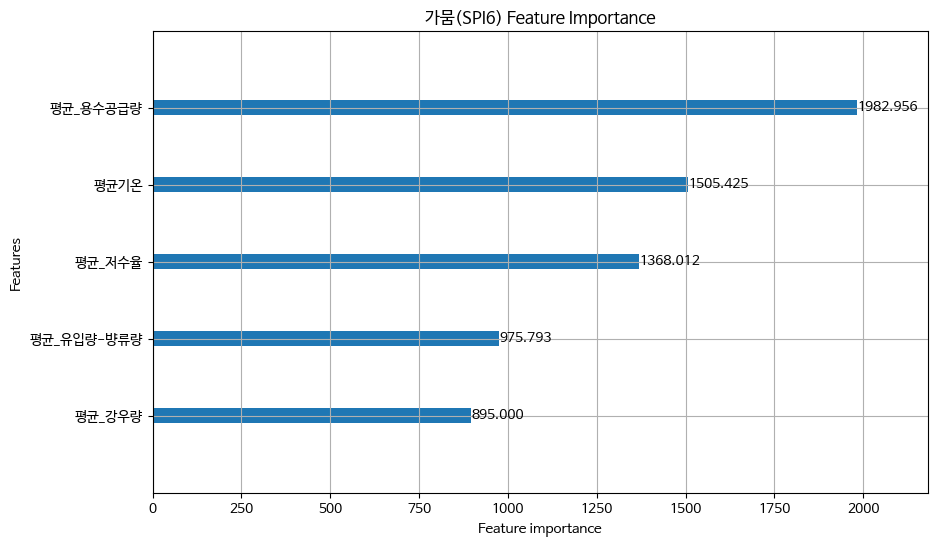

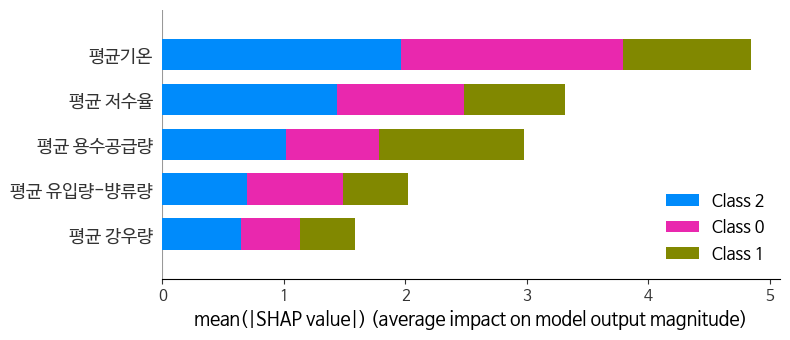

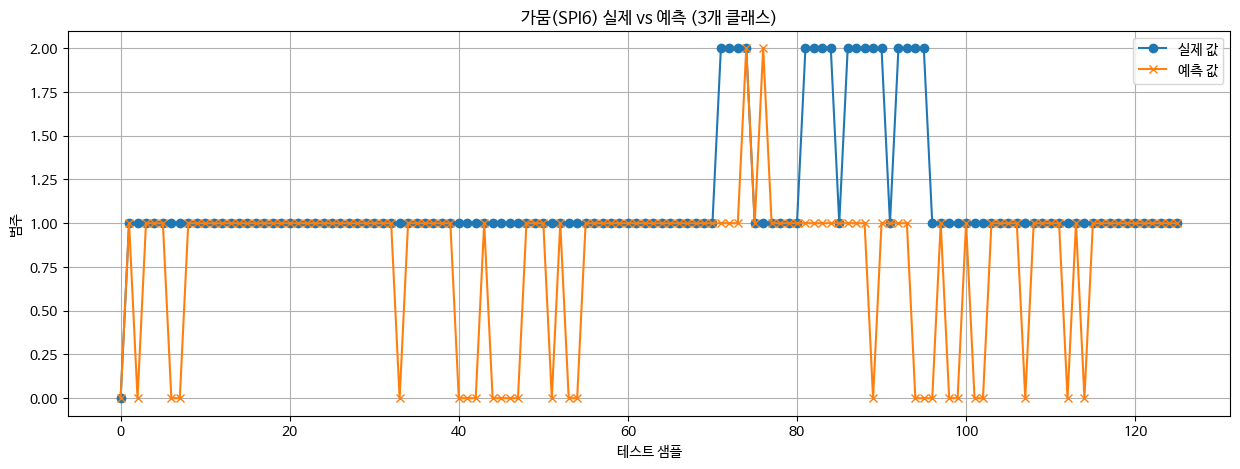

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import shap

# -----------------------------
# 데이터 준비
# -----------------------------
df = pd.read_csv('/content/광동댐_최종_VIF.csv', encoding='cp949')
X = df.drop(['관측일시', '가뭄(MSWSI)', '가뭄(SPI6)'], axis=1)  # DataFrame 유지
targets = ['가뭄(MSWSI)', '가뭄(SPI6)']

# -----------------------------
# y 3개 범주로 변환 함수
# -----------------------------
def categorize_y_3class(y):
    y_cat = []
    for val in y:
        if val < 0:
            y_cat.append(0)   # 음수
        elif val == 0:
            y_cat.append(1)   # 0
        else:
            y_cat.append(2)   # 양수
    return np.array(y_cat)

# -----------------------------
# 스케일링
# -----------------------------
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# -----------------------------
# 각 타겟별 학습
# -----------------------------
results = {}
for target in targets:
    print(f"\n===== {target} 모델 학습 =====")

    y = categorize_y_3class(df[target])

    # train/test 분할 (80:20, shuffle=False)
    split_idx = int(len(X_scaled)*0.8)
    X_train, X_test = X_scaled.iloc[:split_idx], X_scaled.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # LGBMClassifier 정의
    model = LGBMClassifier(
        objective='multiclass',
        num_class=3,
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42
    )

    # 학습
    model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss'
)

    # 예측
    y_pred_class = model.predict(X_test)

    # 평가
    acc  = accuracy_score(y_test, y_pred_class)
    prec = precision_score(y_test, y_pred_class, average='weighted', zero_division=0)
    rec  = recall_score(y_test, y_pred_class, average='weighted', zero_division=0)
    f1   = f1_score(y_test, y_pred_class, average='weighted', zero_division=0)

    results[target] = {
        'model': model,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred_class
    }

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")

    # -----------------------------
    # Feature Importance
    plt.figure(figsize=(10,6))
    model.booster_.feature_importance(importance_type='gain')
    lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10,6))
    plt.title(f'{target} Feature Importance')
    plt.show()

    # -----------------------------
    # SHAP 값 계산 및 시각화
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X.columns)

    # -----------------------------
    # 실제 vs 예측 그래프
    plt.figure(figsize=(15,5))
    plt.plot(y_test, label='실제 값', marker='o')
    plt.plot(y_pred_class, label='예측 값', marker='x')
    plt.title(f'{target} 실제 vs 예측 (3개 클래스)')
    plt.xlabel('테스트 샘플')
    plt.ylabel('범주')
    plt.legend()
    plt.grid(True)
    plt.show()
